<center>
<h1 style="font-family:verdana">
 💻 🧑 Reconeixement d'entitats anomenades 🧑 💻


<p> 🎯 <b>Objectiu</b>: en aquesta segona part de la pràctica aprendrem a reconèixer entitats anomenades, és a dir, identificar i classificar entitats en una oració que poden ser (en el context de reserva de vols) la ciutat de sortida o d'arribada, la data del mes i el dia, si es de negocis o turista o altres categories específiques. Aquesta tasca se sol plantejar etiquetant cada paraula amb una etiqueta de la categoria de l'entitat a la qual correspon.

Tant la classificació d'intencions (tasca estudiada a la primera part) com el reconeixement d'entitats anomenades (Name Entity Recognition, NER) que veurem en aquesta part són components crucials dels sistemes de processament del llenguatge natural (Natural Language Processing, NLP) i sovint s'utilitzen junts per crear aplicacions d'intel·ligència artificial (IA) conversacionals més sofisticades. Per exemple, en un xatbot, la classificació d'intencions ajuda a entendre la intenció principal de l'usuari, mentre que el reconeixement d'entitats anomenades ajuda a extreure entitats rellevants per proporcionar respostes més contextualitzades.


<p> ✨ <b>Contingut</b>: els passos d'aquesta segona part seran similars a la primera. En primer lloc, analitzarem el conjunt de dades. En segon lloc, prepararem les dades per a poder entrenar el model. I finalment dissenyarem l'arquitectura i entrenarem el model. </p>


<p> ✏ <b>Exercicis</b>: en cada secció anireu trobant exercicis que haureu d'anar resolent. </p>

---

<h2> Índex </h2>

1. [Inspecció del conjunt de dades](#section-one)
  * [Exercici 1](#ex-one)
  * [Exercici 2](#ex-two)
2. [Preprocessament de dades](#section-two)
  * [Exercici 3](#ex-three)
  * [Exercici 4](#ex-four)
3. [Disseny del model i entrenament](#section-three)
  * [Exercici 5](#ex-five)
  * [Exercici 6](#ex-six)
4. [Lliurable](#section-four)

---

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import keras
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report
from collections import Counter


<h1><a name="section-one"> 1. Inspecció del conjunt de dades </a></h1>

In [2]:
!pip install gdown
!gdown "https://drive.google.com/uc?id=1u2wzXvsuscLeFHwXcDwMDaNDy0u_99-t"
!tar -zxf nlu_ATIS_data.tar.gz

Downloading...
From: https://drive.google.com/uc?id=1u2wzXvsuscLeFHwXcDwMDaNDy0u_99-t
To: /content/nlu_ATIS_data.tar.gz
100% 122k/122k [00:00<00:00, 2.95MB/s]


In [2]:
!ls data

"ls" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.


En aquesta segona part de la pràctica utilitzarem el mateix dataset que a la primera part, però en aquest cas utilitzarem la **primera columna** que correspon a les **oracions** introduïdes pels usuaris i la **segona columna** on trobarem les oracions d'entrada en format **BILOU**.

El format BILOU  és un esquema d'etiquetatge que es fa servir a les tasques de reconeixement d'entitats anomenades. El nom *BILOU* representa les etiquetes utilitzades en aquest esquema:

*   **B** - Beginning: primer token d'una entitat.
*   **I** - Inside: token dins d'una entitat.
*   **L** - Last: últim token de l'entitat.
*   **O** - Outside: token que no pertany a cap entitat.
*   **U** - Unit: entitats d'un sol token

A continuació, carregarem les dades per visualitzar i poder entendre millor aquestes etiquetes.

---

 <h1><a name="ex-one"><center> ✏ Exercici 1 ✏</a></h1>

A continuació us demanem que carregueu els dos CSVs de la carpeta `data`: `train.csv`, `test.csv` utilitzant pandas. Recorda que aquests CSVs no tenen capçalera. Agafeu les 900 últimes lineas del fitxer `train.csv` per crear un dataframe per validació.

In [3]:
#TODO
train_data = pd.read_csv('data/train.csv', header=None)
val_data = train_data.tail(900)
train_data = pd.read_csv('./data/train.csv', header=None, nrows=4078)
test_data = pd.read_csv('data/test.csv', header=None)

print('Training size:', len(train_data))
print('Validation dataset size:', len(val_data))
print('Test dataset size:', len(test_data))

train_data = train_data.map(lambda x: x.replace('"', ''))
val_data = val_data.map(lambda x: x.replace('"', ''))
test_data = test_data.map(lambda x: x.replace('"', ''))

Training size: 4078
Validation dataset size: 900
Test dataset size: 893


---

 <h1><a name="ex-two"><center> ✏ Exercici 2 ✏</a></h1>

Tal com hem introduït abans, per a aquest exercici ens centrarem en la **primera** i la **segona** columna. Per tant, ara us demanem que guardeu en les següents variables, les llistes corresponents a les oracions i a les etiquetes de les tres particions (`train`, `validation` i `test`).

In [22]:
#TODO
train_sentences = train_data[0].tolist()
train_labels = train_data[1].tolist()

val_sentences = val_data[0].tolist()
val_labels = val_data[1].tolist()

test_sentences = test_data[0].tolist()
test_labels = test_data[1].tolist()


---

Si tot ha anat bé ja podem analitzar quin aspecte té el format BILOU.

In [5]:
print(train_sentences[5])
print(train_labels[5])

i need a flight tomorrow from columbus to minneapolis
 O O O O B-depart_date.today_relative O B-fromloc.city_name O B-toloc.city_name


Aquest hauria de ser el resultat obtingut si executeu la cel·la anterior:

```


i want to fly from boston at 838 am and arrive in denver at 1110 in the morning
 "O O O O O B-fromloc.city_name O B-depart_time.time I-depart_time.time O O O B-toloc.city_name O B-arrive_time.time O O B-arrive_time.period_of_day"


```

En aquest exemple, `boston` i `838 am` corresponen a l'entitat "ciutat de sortida" i a l'entitat "hora de sortida" respectivament (`fromloc.city_name`,`depart_time.time`). `838` correspon al primer token que pertany la entitat `depart_time.time` i `am` al segon de la mateixa entitat. Els tokens com `i` o `want` no pertanyen a cap entitat.

In [16]:
print(train_sentences[1])
print(train_labels[1])

what flights are available from pittsburgh to baltimore on thursday morning
 O O O O O B-fromloc.city_name O B-toloc.city_name O B-depart_date.day_name B-depart_time.period_of_day


I aquest hauria de ser el resultat de la cel·la anterior:

```
what flights are available from pittsburgh to baltimore on thursday morning
 O O O O O B-fromloc.city_name O B-toloc.city_name O B-depart_date.day_name B-depart_time.period_of_day
```

En l'anterior exemple, `what`, `flights`, `are`, `available`, `from`, `to` i `on` estan etiquetades com a no pertanyents a cap entitat. I, en canvi, `pittsburgh` pertany a l'entitat d'un sol token anomenada ciutat d'arribada (`toloc.city_name`). També hi ha entitats compostes com `baltimore` que pertany a l'entitat ciutat de sortida (`fromloc.city_name`) i `thursday morning` que pertanyen a les entitats data de sortida (`depart_date.day_name`, `depart_time.period_of_day`).

Vegem-ne la llista completa d'entitats.

In [ ]:

def count_unique_entities(list_of_label_sentences):
  flat_labels = []
  for labels in list_of_label_sentences:
    flat_labels += labels.split()
  c = Counter(flat_labels)
  return len(c), list(c.keys())

num_unique_entities, unique_entities = count_unique_entities(train_labels)

print("Number of different entities:", num_unique_entities)

print("Unique entities:", unique_entities)

Number of different entities: 119
Unique entities: ['O', 'B-fromloc.city_name', 'B-depart_time.time', 'I-depart_time.time', 'B-toloc.city_name', 'B-arrive_time.time', 'B-arrive_time.period_of_day', 'B-depart_date.day_name', 'B-depart_time.period_of_day', 'B-flight_time', 'I-flight_time', 'I-fromloc.city_name', 'B-cost_relative', 'B-round_trip', 'I-round_trip', 'B-fare_amount', 'I-fare_amount', 'B-depart_date.today_relative', 'I-toloc.city_name', 'B-city_name', 'B-stoploc.city_name', 'B-toloc.airport_code', 'B-depart_time.time_relative', 'B-class_type', 'I-class_type', 'B-depart_date.date_relative', 'B-airline_name', 'I-airline_name', 'B-arrive_time.time_relative', 'B-depart_time.start_time', 'I-depart_time.start_time', 'B-depart_time.end_time', 'I-depart_time.end_time', 'B-fromloc.airport_name', 'I-fromloc.airport_name', 'B-toloc.state_name', 'B-depart_date.day_number', 'I-depart_date.day_number', 'B-depart_date.month_name', 'B-mod', 'B-fare_basis_code', 'B-transport_type', 'B-flight_m

<h1><a name="section-two"> 2. Preprocessament de dades </a></h1>

El processament de les dades serà semblant al de la primera part d'aquesta pràctica.

---

 <h1><a name="ex-three"><center> ✏ Exercici 3 ✏</a></h1>

En aquest exercici us demanem que realitzeu els passos següents per preparar les dades.

 1. El primer pas serà construir el vocabulari a partir de les paraules presents a les oracions d'entrenament.

2. El segon pas serà convertir les oracions en seqüències de nombres enters usant el tokenitzador.

3. El tercer pas serà guardar la longitud original de cada oració. Això ens serà útil per evaluar el nostre model sense tenir en compte el padding.

3. Finalment, per aconseguir que totes les seqüències tinguen la mateixa longitud, fixarem la longitud segons la màxima trobada a l'entrenament i afegirem zeros a les oracions de menor longitud.

Recordeu que podeu consultar com fer-ho a la documentació de la llibrería:
* <a href="https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer"> Tokenizer </a>
* <a href="https://www.tensorflow.org/api_docs/python/tf/keras/utils/pad_sequences"> Pad Sequences </a>




In [33]:
#TODO
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_sentences)

train_sequences = tokenizer.texts_to_sequences(train_sentences)
len_train_sequences = [len(seq) for seq in train_sequences]
max_sequence_length = max(len_train_sequences)
print("Max sequence length:", max_sequence_length)
train_pad_sequences = pad_sequences(train_sequences, maxlen=max_sequence_length, padding='post')

val_sequences = tokenizer.texts_to_sequences(val_sentences)
len_val_sequences = [len(seq) for seq in val_sequences]
val_pad_sequences = pad_sequences(val_sequences, maxlen=max_sequence_length, padding='post')

test_sequences = tokenizer.texts_to_sequences(test_sentences)
len_test_sequences = [len(seq) for seq in test_sequences]
test_pad_sequences = pad_sequences(test_sequences, maxlen=max_sequence_length, padding='post')

Max sequence length: 46


In [34]:
print("-------------Sequences shape------------")
print("Train sequences padded shape:", train_pad_sequences.shape)
print("Test sequences padded shape:", test_pad_sequences.shape)
print("Validation sequences padded shape:", val_pad_sequences.shape)


-------------Sequences shape------------
Train sequences padded shape: (4078, 46)
Test sequences padded shape: (893, 46)
Validation sequences padded shape: (900, 46)



---



Tal com vam fer a la primera part, aquí també hem de convertir les diferents classes d'entitats en vectors one-hot.

---

 <h1><a name="ex-four"><center> ✏ Exercici 4 ✏</a></h1>

Per aconseguir-ho haureu de seguir els passos següents.

 1. En primer lloc, haureu d'esbrinar quantes etiquetes diferents hi ha. Podeu prendre com a exemple la funció `count_unique_entities` per fer-ho. Tingueu en compte que haureu de modificar la funció, ja que per exemple aquesta funció considera que `B-depart_time.time`, `I-depart_time.time`, `L-depart_time.time`, `U-depart_time.time` són la mateixa entitat. En aquest exercici, necessitarem comptar-les per separat. També l'entitat O ha de ser considerada com una classe.

 2. El segon pas serà codificar les diferents classes trobades en etiquetes numèriques. Tingueu en compte que cada paraula de l'oració té una etiqueta i, per tant, per a cada oració tindrem una llista d'etiquetes. El *padding* el codificarem amb l'etiqueta corresponent a **O** (outside). Per ajudar-vos hem preparat el processament per a les etiquetes d'entrenament, intenteu comprendre el que es fa i així repetir-ho per a la partició de validació i test.

 3. Finalment, haureu de convertir les diferents classes a vectors one-hot. Recordeu de nou que per a cada oració tindrem una llista de vectors one-hot.


 Podeu consultar els apartats de la documentació:
 * <a href=https://www.tensorflow.org/guide/keras/understanding_masking_and_padding> Masking and Padding </a>

 * <a href=https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical> To Categorical </a>



In [45]:
#TODO
#Step 1
def count_unique_entities(list_of_label_sentences):
  flat_labels = []
  for labels in list_of_label_sentences:
    flat_labels += labels.split()
  unique_entities = Counter(flat_labels)
  return len(unique_entities), unique_entities

num_unique_entities, unique_entities = count_unique_entities(train_labels)
print("-------------Train labels exploration------------")
print("Number of different entities:", num_unique_entities)
print("Unique entities:", unique_entities)

#Step 2
label_encoder = LabelEncoder()
label_encoder.fit(list(unique_entities.keys()))
train_numerical_labels = [label_encoder.transform(labels.split()).tolist() for labels in train_labels]
train_pad_labels = pad_sequences(train_numerical_labels, maxlen=max_sequence_length, padding='post', value=label_encoder.transform(['O']))

def remove_sentences(list_labels, list_sequences):
  idx_to_remove = []
  labels_to_remove = set()
  for idx, labels in enumerate(list_labels):
    for label in labels.split():
      if label not in unique_entities:
        idx_to_remove.append(idx)
        labels_to_remove.add(label)

  labels = [elem for i, elem in enumerate(list_labels) if i not in idx_to_remove]
  sequences = [elem for i, elem in enumerate(list_sequences) if i not in idx_to_remove]
  print("Original size:", len(list_labels))
  print("Removed sentences:", len(idx_to_remove))
  print("Labels removed:", set(labels_to_remove))
  return labels, np.array(sequences)

print("-------------Test labels codification------------")
test_labels_cleaned, test_pad_sequences = remove_sentences(test_labels, test_pad_sequences)
test_numerical_labels = [label_encoder.transform(labels.split()).tolist() for labels in test_labels_cleaned]
test_pad_labels = pad_sequences(test_numerical_labels, maxlen=max_sequence_length, padding='post', value=label_encoder.transform(['O']))

print("-------------Validation labels codification------------")
val_labels_cleaned, val_pad_sequences = remove_sentences(val_labels, val_pad_sequences)
val_numerical_labels = [label_encoder.transform(labels.split()).tolist() for labels in val_labels_cleaned]
val_pad_labels = pad_sequences(val_numerical_labels, maxlen=max_sequence_length, padding='post', value=label_encoder.transform(['O']))

#Step 3
train_labels_one_hot = to_categorical(train_pad_labels, num_classes=len(label_encoder.classes_))
test_labels_one_hot = to_categorical(test_pad_labels, num_classes=len(label_encoder.classes_))
val_labels_one_hot = to_categorical(val_pad_labels, num_classes=len(label_encoder.classes_))
print("-------------One-hot encoding shapes------------")
print("Train labels one-hot shape:", train_labels_one_hot.shape)
print("Test labels one-hot shape:", test_labels_one_hot.shape)
print("Validation labels one-hot shape:", val_labels_one_hot.shape)
print("-------------Sequence shapes------------")
print("Train sequences shape:", train_pad_sequences.shape)
print("Test sequences shape:", test_pad_sequences.shape)
print("Validation sequences shape:", val_pad_sequences.shape)

-------------Train labels exploration------------
Number of different entities: 119
Unique entities: Counter({'O': 29586, 'B-toloc.city_name': 3571, 'B-fromloc.city_name': 3549, 'I-toloc.city_name': 898, 'B-depart_date.day_name': 745, 'B-airline_name': 575, 'I-fromloc.city_name': 564, 'B-depart_time.period_of_day': 491, 'I-airline_name': 352, 'B-depart_date.day_number': 316, 'B-depart_time.time': 307, 'B-depart_date.month_name': 303, 'B-round_trip': 275, 'B-flight_mod': 275, 'B-cost_relative': 273, 'B-depart_time.time_relative': 271, 'I-round_trip': 268, 'I-depart_time.time': 249, 'B-stoploc.city_name': 205, 'B-arrive_time.time': 178, 'B-city_name': 177, 'B-class_type': 177, 'B-arrive_time.time_relative': 161, 'I-class_type': 148, 'B-flight_stop': 140, 'I-arrive_time.time': 139, 'B-airline_code': 114, 'I-depart_date.day_number': 96, 'I-fromloc.airport_name': 88, 'B-toloc.state_code': 71, 'B-arrive_date.day_name': 70, 'B-depart_date.today_relative': 66, 'B-fromloc.airport_name': 66, 'B-

<h1><a name="section-three"> 3. Disseny del model i entrenament </a></h1>

---
<h1><a name="ex-five"><center> ✏ Exercici 5 ✏</a></h1>

De forma similar com féreu a la primera part de la pràctica us demanem que dissenyeu l'arquitectura i entreneu el model. Podeu fer servir una arquitectura similar. Ara bé, per capturar les dependències seqüencials podeu canviar la capa de GlobalMaxPooling1D per una LSTM.

In [38]:
s = train_pad_labels.shape
train_flat_labels = train_pad_labels.reshape(s[0]*s[1])
train_unq_labels = np.unique(train_flat_labels)
print(train_flat_labels.shape, train_unq_labels)

s = test_pad_labels.shape
test_flat_labels = test_pad_labels.reshape(s[0]*s[1])
test_unq_labels = np.unique(test_flat_labels)
print(test_flat_labels.shape, test_unq_labels)

s = val_pad_labels.shape
val_flat_labels = val_pad_labels.reshape(s[0]*s[1])
val_unq_labels = np.unique(val_flat_labels)
print(val_flat_labels.shape, val_unq_labels)

(187588,) [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118]
(40710,) [  0   1   2   3   4   5   6   7   8  10  12  13  14  15  16  17  18  19
  20  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38
  39  40  41  42  43  44  45  46  47  48  49  50  51  53  54  55  56  61
  62  63  65  70  71  72  73  74  75  76  77  78  80  82  83  84  85  86
  87  89  91  92  93  94  95  97  99 101 102 103 104 107 108 110 111 114
 115 116 117 118]
(41262,) [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  23  24  25  26  27  28

In [7]:
class TransformerBlock(keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1): #num_heads no es full attention
        super().__init__()
        self.att = keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.ffn = keras.Sequential(
            [
                keras.layers.Dense(ff_dim, activation="relu"),
                keras.layers.Dense(embed_dim),
            ]
        )
        self.layernorm1 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = keras.layers.Dropout(rate)
        self.dropout2 = keras.layers.Dropout(rate)

    def call(self, inputs, training=False): #Training argument for dropout layers when training
        attn_output = self.att(inputs, inputs) #Self-attention
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


class TokenAndPositionEmbedding(keras.layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = keras.layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.pos_emb = keras.layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, inputs):
        maxlen = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        position_embeddings = self.pos_emb(positions)
        token_embeddings = self.token_emb(inputs)
        return token_embeddings + position_embeddings





In [46]:
print("-------------Shapes of one-hot labels and padded sequences------------")
print("Train labels one-hot shape:", train_labels_one_hot.shape)
print("Train sequences padded shape:", train_pad_sequences.shape)
print("Test labels one-hot shape:", test_labels_one_hot.shape)
print("Test sequences padded shape:", test_pad_sequences.shape)
print("Validation labels one-hot shape:", val_labels_one_hot.shape)
print("Validation sequences padded shape:", val_pad_sequences.shape)


-------------Shapes of one-hot labels and padded sequences------------
Train labels one-hot shape: (4078, 46, 119)
Train sequences padded shape: (4078, 46)
Test labels one-hot shape: (885, 46, 119)
Test sequences padded shape: (885, 46)
Validation labels one-hot shape: (897, 46, 119)
Validation sequences padded shape: (897, 46)


In [47]:
#TODO
embedding_dim = 128
vocab_size = len(tokenizer.word_index) + 1
num_heads = 4
ff_dim = 128
num_classes = len(label_encoder.classes_)
print("Parameters:")
print("Embedding Dimension:", embedding_dim)
print("Vocabulary Size:", vocab_size)
print("Number of Heads:", num_heads)
print("Feed Forward Dimension:", ff_dim)
print("Number of Classes:", num_classes)

model = Sequential()
model.add(TokenAndPositionEmbedding(max_sequence_length, vocab_size, embedding_dim))
model.add(TransformerBlock(embedding_dim, num_heads, ff_dim))
#model.add(keras.layers.GlobalAveragePooling1D())
model.add(keras.layers.Dense(num_classes, activation="softmax"))

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# Train the model
batch_size = 32
epochs = 10
model.fit(train_pad_sequences, train_labels_one_hot, batch_size=batch_size, epochs=epochs, validation_data=(val_pad_sequences, val_labels_one_hot))

# Evaluate the model on the test set
loss, accuracy = model.evaluate(test_pad_sequences, test_labels_one_hot)
print(f"Test accuracy: {accuracy:.2f}")


Parameters:
Embedding Dimension: 128
Vocabulary Size: 831
Number of Heads: 4
Feed Forward Dimension: 128
Number of Classes: 119
Epoch 1/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - accuracy: 0.8993 - loss: 0.5430 - val_accuracy: 0.9683 - val_loss: 0.1327
Epoch 2/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.9741 - loss: 0.0754 - val_accuracy: 0.9716 - val_loss: 0.1215
Epoch 3/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.9778 - loss: 0.0600 - val_accuracy: 0.9752 - val_loss: 0.1165
Epoch 4/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.9824 - loss: 0.0492 - val_accuracy: 0.9799 - val_loss: 0.1074
Epoch 5/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.9871 - loss: 0.0385 - val_accuracy: 0.9824 - val_loss: 0.1034
Epoch 6/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.9905 - loss: 0.0301 - val_accuracy: 0.9836 - val_loss: 0.1035
Epoch 7/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.9922 - loss: 0.0247 - val_accur

In [48]:
preds = model.predict(test_pad_sequences)

28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


In [49]:
preds.shape

(885, 46, 119)

In [12]:
def preds_to_index(preds, seq_lens):
  '''
  Turn predictions to numerical indexes, flatten the sentences and discard padding.
  '''
  idx_preds = []
  for pred, seq_len in zip(preds,seq_lens):
      for l in range(seq_len):
        idx_preds.append(np.argmax(pred[l]))
  return idx_preds



Com ja sabeu, NER es una tasca on les dades estan molt desbalancejades. La gran majoria de les nostres etiquetes serán 'O' (outside). Es pot donar el cas on el model tingui una accuracy molt alta predint sempre 'O'.

Per mesurar millor com de bó és el nostre model, calcularem la F1 score per cada classe, així com la mitjana (macro average). Quan prepareu el vostre document, heu de reportar aquesta mitjana com a mètrica del vostre model, no l'acuracy.

In [53]:
test_labels_idx = preds_to_index(test_labels_one_hot,len_test_sequences)
preds_idx = preds_to_index(preds, len_test_sequences)

print(classification_report(test_labels_idx, preds_idx, zero_division=1.0))

              precision    recall  f1-score   support

           0       1.00      0.71      0.83        24
           1       0.89      0.83      0.86        29
           2       0.95      0.96      0.96        79
           3       1.00      0.12      0.22         8
           4       0.86      0.33      0.48        18
           5       1.00      1.00      1.00         1
           6       0.50      0.29      0.36         7
           7       0.50      0.33      0.40         3
           8       1.00      0.67      0.80         3
          12       0.67      1.00      0.80         2
          13       1.00      0.00      0.00         3
          14       0.58      0.85      0.69        13
          15       0.86      0.86      0.86        14
          16       0.71      0.63      0.67        43
          17       0.92      1.00      0.96        24
          18       1.00      0.67      0.80         6
          19       1.00      1.00      1.00        33
          20       1.00    

A continuació podeu veure algunes prediccions del model.

In [54]:
probs = model.predict(test_pad_sequences)
_predicted_labels = np.argmax(probs, axis=2)

predicted_labels = [list(label_encoder.inverse_transform(label)) for label in _predicted_labels]

for i in range(0, 10):
    print('Sentence: ', test_sentences[i])
    print('Original label: ', test_labels[i])
    print('Predicted label: ', predicted_labels[i])
    print()

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Sentence:  i would like to find a flight from charlotte to las vegas that makes a stop in st. louis
Original label:   O O O O O O O O B-fromloc.city_name O B-toloc.city_name I-toloc.city_name O O O O O B-stoploc.city_name I-stoploc.city_name
Predicted label:  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-fromloc.city_name', 'O', 'B-toloc.city_name', 'I-toloc.city_name', 'O', 'O', 'O', 'O', 'O', 'B-stoploc.city_name', 'I-stoploc.city_name', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Sentence:  on april first i need a ticket from tacoma to san jose departing before 7 am
Original label:   O B-depart_date.month_name B-depart_date.day_number O O O O O B-fromloc.city_name O B-toloc.city_name I-toloc.city_name O B-depart_time.time_relative B-depart_time.time I-depart_time.time
Predicted label:  ['O', 'B-depart_date.month_name', 'B-class_type', 'O', 'O', 'O', 'O', 

---

 <h1><a name="ex-six"><center> ✏ Exercici 6 ✏ </a></h1>

Modifiqueu els següents paràmetres del model anterior i analitzeu com afecten a la seva *accuracy*:

 1. **Mida dels Embeddings.** Proveu diferents mides d'*Embeddings* i observeu com canvia l'*accuracy* del model. Heu d'explicar les vostres conclusions.

 2. **Xarxes Convolucionals.** Afegiu capes convolucionals al vostre model. Expliqueu amb detall els valors que heu provat i la vostra motivació a l'hora d'escollir-los. Recordeu, que també podeu provar diferents configuracions de *pooling*.

 3. **Xarxes Recurrents.**  Afegiu capes recurrents al vostre model (LSTM, GRU). Expliqueu amb detall els valors que heu provat i la vostra motivació.

 4. ** Transformer.** Afegiu blocs de Transformer al vostre model. Expliqueu amb detall els valors que heu provat i la vostra motivació.

 5. **Regularització.** Quan proveu configuracions amb més paràmetres veureu que el model comença a tenir *overfitting* molt prompte durant l'entrenament. Afegiu *Dropout* al vostre model. Heu d'explicar la vostra decisió de valors i de posició dins de la xarxa.


 6. **Balancejat de les classes.** Si analitzeu el dataset, veureu que la freqüència de les classes està molt desbalancejada. Keras us permet afegir un pes per a cada classe a l'hora de calcular la loss (Mireu el paràmetre "class_weigth" a la documentació https://keras.io/api/models/model_training_apis/). Calculeu un pes per a cada classe i afegiu-lo al mètode fit del vostre model.

 ---

In [5]:
(train_pad_sequences, train_labels_one_hot,
val_pad_sequences, val_labels_one_hot,
test_pad_sequences, test_labels_one_hot,
tokenizer, label_encoder, max_sequence_length,len_test_sequences) = iniciar_datoset()

In [9]:
#----------------------Diferents mides d'embedding----------------------
batch_size = 32
epochs = 10
vocab_size = len(tokenizer.word_index) + 1
num_heads = 4
ff_dim = 128
num_classes = len(label_encoder.classes_)

embedding_dims = [32, 64, 128, 256, 384, 512]

results = {} #To store results(f1-score and macro average) for different embedding dimensions
for embedding_dim in embedding_dims:
    print(f"Training model with embedding dimension: {embedding_dim}")
    model = Sequential()
    model.add(TokenAndPositionEmbedding(max_sequence_length, vocab_size, embedding_dim))
    model.add(TransformerBlock(embedding_dim, num_heads, ff_dim))
    model.add(keras.layers.Dense(num_classes, activation="softmax"))

    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

    # Train the model
    model.fit(train_pad_sequences, train_labels_one_hot, batch_size=batch_size, epochs=epochs, validation_data=(val_pad_sequences, val_labels_one_hot))

    # Evaluate the model on the test set
    loss, accuracy = model.evaluate(test_pad_sequences, test_labels_one_hot)
    print(f"Test accuracy with embedding dimension {embedding_dim}: {accuracy:.2f}")

    preds = model.predict(test_pad_sequences)

    
    test_labels_idx = preds_to_index(test_labels_one_hot,len_test_sequences)
    preds_idx = preds_to_index(preds, len_test_sequences)

    report = classification_report(test_labels_idx, preds_idx, zero_division=1.0, output_dict=True)
    results[embedding_dim] = report

Training model with embedding dimension: 32
Epoch 1/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.8589 - loss: 1.4299 - val_accuracy: 0.9109 - val_loss: 0.5813
Epoch 2/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9109 - loss: 0.5460 - val_accuracy: 0.9109 - val_loss: 0.4788
Epoch 3/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9101 - loss: 0.4738 - val_accuracy: 0.9108 - val_loss: 0.4553
Epoch 4/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9101 - loss: 0.4483 - val_accuracy: 0.9106 - val_loss: 0.4187
Epoch 5/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9092 - loss: 0.4129 - val_accuracy: 0.9111 - val_loss: 0.3883
Epoch 6/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9086 - loss: 0.3922 - val_accuracy: 0.9129 - val_loss: 0.3626
Epoch 7/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9114 - loss: 0.3592 - val_accuracy: 0.9146 - val_loss: 0.3383
Epoch 8/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step 

-------------Plot results (f1-score and macro average)------------


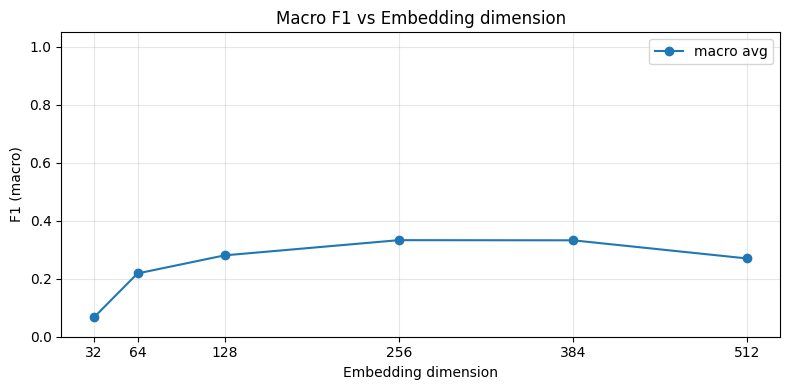

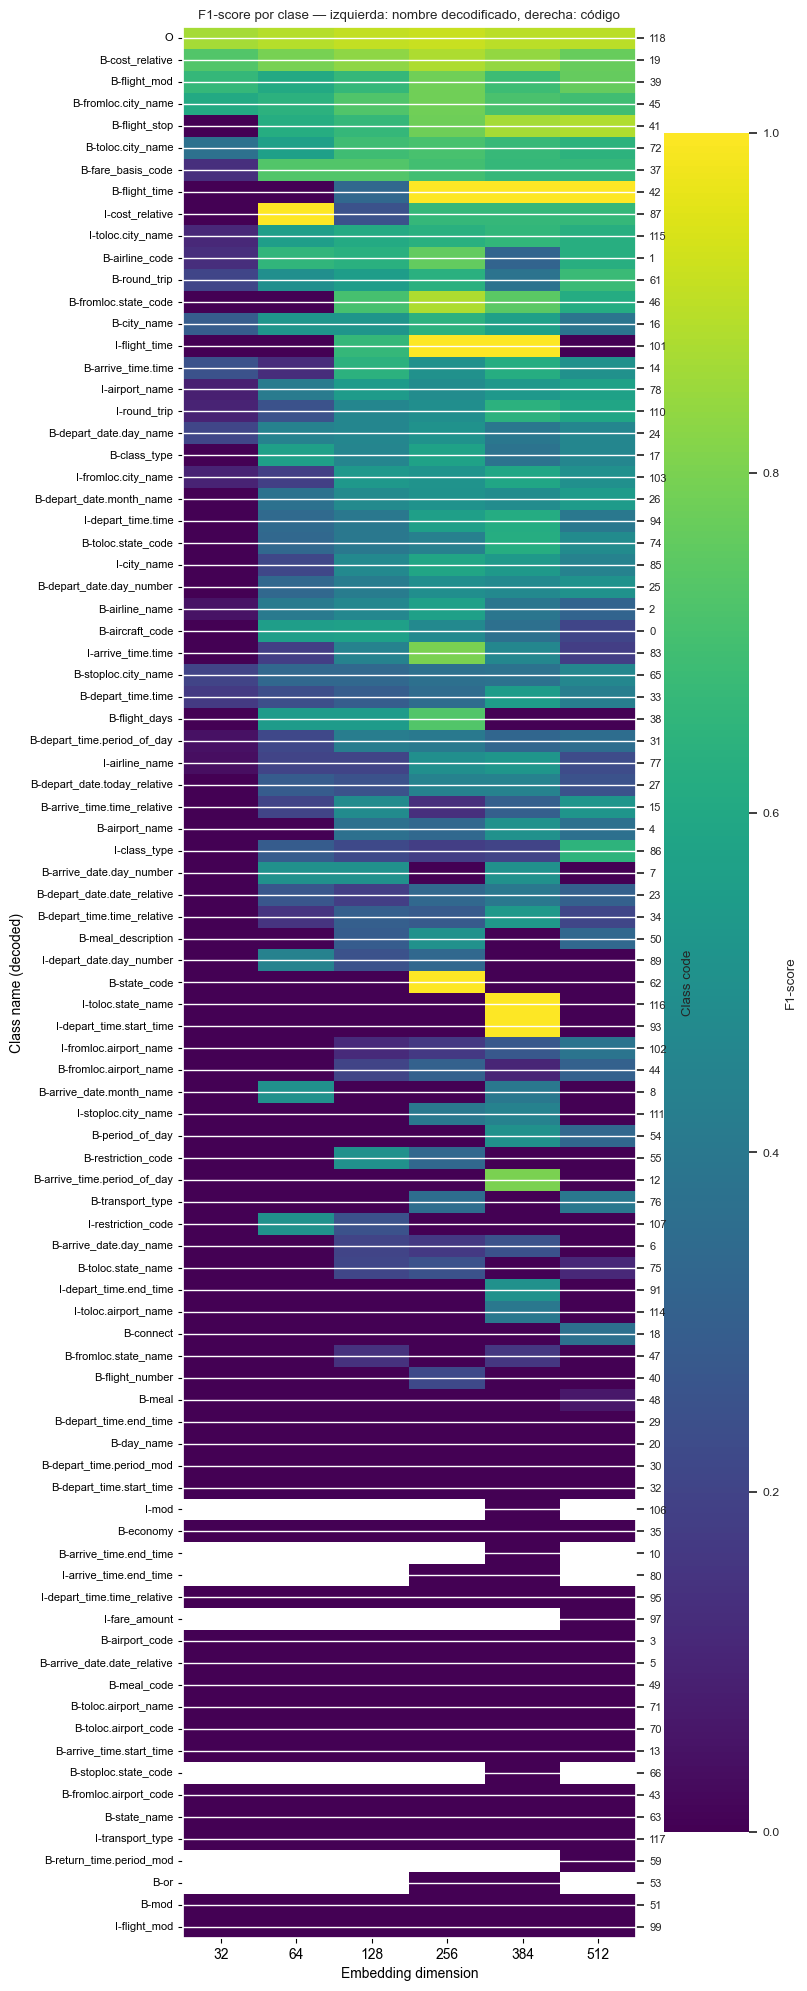

In [10]:
print("-------------Plot results (f1-score and macro average)------------")
# Tengo los reports para cada embedding dimension en el diccionario results
# ...existing code...
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# results debe existir: results[embedding_dim] = classification_report(..., output_dict=True)
embedding_dims_sorted = sorted(results.keys())

# identificar etiquetas (excluyendo agregados)
agg_keys = {'accuracy', 'macro avg', 'weighted avg', 'micro avg'}
all_labels = set()
for rep in results.values():
    all_labels.update(rep.keys())
class_labels = sorted([l for l in all_labels if l not in agg_keys])

# construir DataFrame con f1 por clase
df = pd.DataFrame(index=embedding_dims_sorted, columns=class_labels, dtype=float)
for dim in embedding_dims_sorted:
    rep = results[dim]
    for lbl in class_labels:
        val = rep.get(lbl, {})
        if isinstance(val, dict):
            f1 = val.get('f1-score', val.get('f1_score', np.nan))
        else:
            f1 = np.nan
        df.at[dim, lbl] = float(f1) if not pd.isna(f1) else np.nan

# serie con macro average f1
macro = pd.Series(
    [results[d].get('macro avg', {}).get('f1-score', results[d].get('macro avg', {}).get('f1_score', np.nan))
     for d in embedding_dims_sorted],
    index=embedding_dims_sorted
)
# Plot: macro average
plt.figure(figsize=(8,4))
plt.plot(embedding_dims_sorted, macro.values, marker='o', linestyle='-', label='macro avg')
plt.title('Macro F1 vs Embedding dimension')
plt.xlabel('Embedding dimension')
plt.ylabel('F1 (macro)')
plt.xticks(embedding_dims_sorted)
plt.ylim(0, 1.05)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

def idx_to_label(k):
    # k puede ser string (p. ej. '0') o int
    try:
        # intentar convertir a entero
        i = int(str(k))
        return label_encoder.inverse_transform([i])[0]
    except Exception:
        # si no se puede convertir, devolver tal cual (es probable que ya sea nombre)
        return k 

# Para visualizar todas las clases en el eje y, reorientar: filas=clases, cols=embedding dims
heat_df = df.T  # ahora index = clases, columns = embedding dims

# Opcional: ordenar clases por F1 promedio descendente (más informativo)
heat_df['mean_f1'] = heat_df.mean(axis=1)
heat_df = heat_df.sort_values('mean_f1', ascending=False).drop(columns='mean_f1')

# Preparar etiquetas: izquierda = nombre decodificado, derecha = código original
# heat_df.index contiene las claves usadas en el classification_report (p. ej. '0','1' o nombres)
codes = list(heat_df.index)
names = [idx_to_label(c) for c in codes]

fig, ax = plt.subplots(figsize=(max(8, 0.4 * heat_df.shape[1] + 4),
                                min(20, 0.25 * heat_df.shape[0] + 4)))
sns.set(font_scale=0.8)
sns.heatmap(heat_df, annot=False, fmt='.2f', cmap='viridis',
            vmin=0.0, vmax=1.0, cbar_kws={'label': 'F1-score'}, ax=ax)

# posiciones y-ticks bien alineadas con filas del dataframe
n = len(codes)
yticks_pos = np.arange(n) + 0.5
ax.set_yticks(yticks_pos)
ax.set_yticklabels(names, rotation=0, fontsize='small')
ax.set_xlabel('Embedding dimension')
ax.set_ylabel('Class name (decoded)')

# eje derecho con los códigos
ax2 = ax.twinx()
ax2.set_ylim(ax.get_ylim())
ax2.set_yticks(yticks_pos)
ax2.set_yticklabels([str(c) for c in codes], rotation=0, fontsize='small')
ax2.set_ylabel('Class code', labelpad=10)

plt.title('F1-score por clase — izquierda: nombre decodificado, derecha: código')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()



In [11]:
#----------------------Afegir capes convolucionals en lloc de TransformerBlock----------------------
from keras.layers import MaxPooling1D, UpSampling1D, TimeDistributed
batch_size = 32
epochs = 10
vocab_size = len(tokenizer.word_index) + 1
num_heads = 4
ff_dim = 128
num_classes = len(label_encoder.classes_)
embedding_dim = 128
model = Sequential()
model.add(TokenAndPositionEmbedding(max_sequence_length, vocab_size, embedding_dim))

# Bloque conv 1 + pooling (reduce temporalmente la longitud)
model.add(keras.layers.Conv1D(filters=128, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2, padding='same'))  # pooling

# Bloque conv 2
model.add(keras.layers.Conv1D(filters=128, kernel_size=3, padding='same', activation='relu'))

# Restaurar la longitud temporal con upsampling (mantener alineación con etiquetas)
model.add(UpSampling1D(size=2))

# Refinamiento final de características por timestep
model.add(keras.layers.Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'))

# Capa final por timestep: TimeDistributed para aplicar Dense a cada timestep
model.add(TimeDistributed(keras.layers.Dense(num_classes, activation='softmax')))

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
# Train the model
model.fit(train_pad_sequences, train_labels_one_hot, batch_size=batch_size, epochs=epochs, validation_data=(val_pad_sequences, val_labels_one_hot))
# Evaluate the model on the test set
loss, accuracy = model.evaluate(test_pad_sequences, test_labels_one_hot)
print(f"Test accuracy with embedding dimension {embedding_dim}: {accuracy:.2f}")

preds = model.predict(test_pad_sequences)


test_labels_idx = preds_to_index(test_labels_one_hot,len_test_sequences)
preds_idx = preds_to_index(preds, len_test_sequences)

print(classification_report(test_labels_idx, preds_idx, zero_division=1.0))


Epoch 1/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.8640 - loss: 2.0827 - val_accuracy: 0.9109 - val_loss: 1.4354
Epoch 2/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9101 - loss: 1.4474 - val_accuracy: 0.9109 - val_loss: 1.4288
Epoch 3/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9109 - loss: 1.0771 - val_accuracy: 0.9109 - val_loss: 0.4784
Epoch 4/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9103 - loss: 0.4726 - val_accuracy: 0.9109 - val_loss: 0.4622
Epoch 5/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9098 - loss: 0.4622 - val_accuracy: 0.9109 - val_loss: 0.4584
Epoch 6/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9105 - loss: 0.4522 - val_accuracy: 0.9109 - val_loss: 0.4553
Epoch 7/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9086 - loss: 0.4603 - val_accuracy: 0.9109 - val_loss: 0.4548
Epoch 8/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9107 - loss: 0.4502 - val_accu

---

<h1><a name="section-four"> 4. Lliurable </a></h1>

Heu d'entregar un document PDF de com a **màxim 10 pàgines** que incloga els resultats de tots els exercicis així com una explicació de cadascun dels resultats i de la modificació que heu fet. L'estructura del document és:

1. Introducció.
2. Experiments i Resultats (amb raonament).
3. Conclusions.

No cal que afegiu el vostre codi al document, podeu entregar el *notebook* juntament amb el document.

 ---